# Testing body-to-field operators in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [19]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Testing body-to-field operations

In [2]:
ddf = DDF();
x = linspace(-4,4,401);
plot(x,ddf.(x),legend=false)

LoadError: [91mUndefVarError: plot not defined[39m

In [3]:
x = [0.25,0.75,0.25]; y = [0.75,0.25,0.25];
X = VectorData(x,y);
q = Edges(Primal,(12,12));
dx = 0.1;
H = Regularize(x,y,dx)

Regularization/interpolation operator with non-filtered interpolation
  3 points in grid with cell area 0.01


#### Set up a circle of points

In [2]:
n = 100;
θ = linspace(0,2π,n+1);
x = 0.5 + 0.25*cos.(θ[1:n])
y = 0.5 + 0.25*sin.(θ[1:n])
ds = 2π/n*0.25;
X = VectorData(x,y);
f = ScalarData(X);

#### Set up the physical dimensions of the grid and create empty data

In [3]:
nx = 102; ny = 102;
Lx = 1.0;
dx = Lx/(nx-2);
q = Edges(Primal,(nx,ny));
w = Nodes(Dual,(nx,ny));
w̃ = Nodes(Primal,w);
p = Edges(Dual,w);

#### Create a regularization operator with the point data

In [4]:
H = Regularize(X,dx;weights=ds)

Regularization/interpolation operator with non-filtered interpolation
  100 points in grid with cell area 0.0001


In [6]:
H̃ = Regularize(X,dx;weights=ds,filter=true)

Regularization/interpolation operator with filtered interpolation
  100 points in grid with cell area 0.0001


#### Now set up some data on the points and regularize it to primal edge data on the grid 

In [5]:
using BenchmarkTools

In [15]:
f = VectorData(X)
fill!(f.u,1.0);
f.v .= X.v.-0.5;
@btime H(q,f);

  44.679 ms (123624 allocations: 37.10 MiB)


In [6]:
f = VectorData(X)
fill!(f.u,1.0);
f.v .= X.v.-0.5;
@btime H(q,f);

  16.018 ms (185436 allocations: 55.65 MiB)


In [20]:
@time for y in 1:ny, x in 1:nx
    #dot(H.buffer,H.buffer2)
    At_mul_B(H.buffer,H.buffer2)
end

  0.005353 seconds (52.23 k allocations: 9.849 MiB)


We can also create a matrix representation of the regularization, and apply it:

In [15]:
Hmat = RegularizationMatrix(H,f,q);

Notice that it is a lot faster:

In [17]:
@time q = Hmat*f;

  0.000049 seconds (13 allocations: 203.375 KiB)


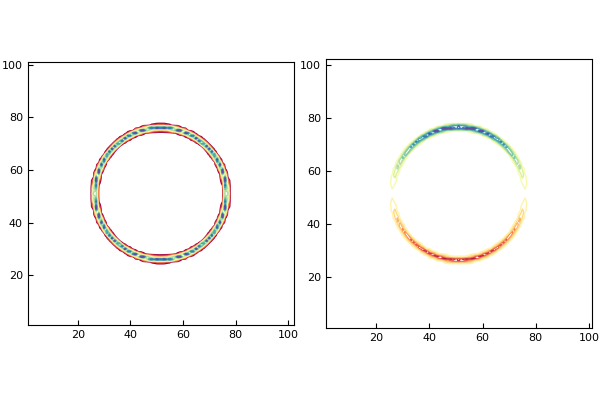

In [17]:
plot(q)

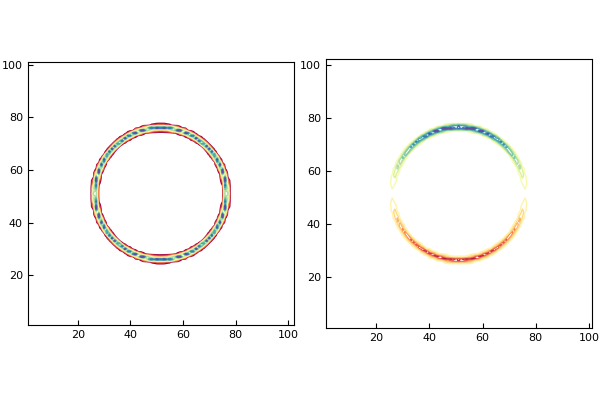

In [18]:
q2 = Edges(Primal,(nx,ny));
H(q2,f)
plot(q2)

In [18]:
@time H(q,f);

  0.052573 seconds (123.63 k allocations: 37.098 MiB, 13.38% gc time)


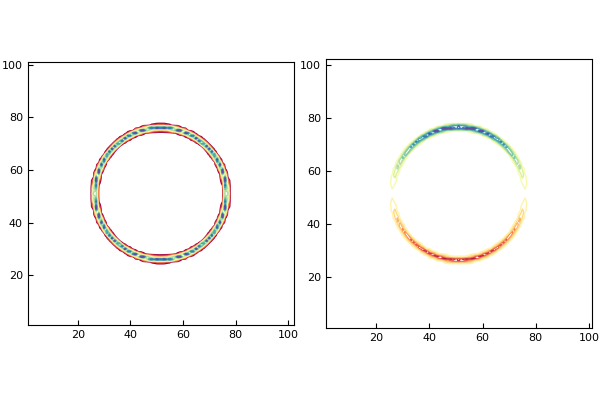

In [20]:
H(q,f);
plot(q)

  0.148526 seconds (204.27 k allocations: 57.200 MiB, 7.80% gc time)


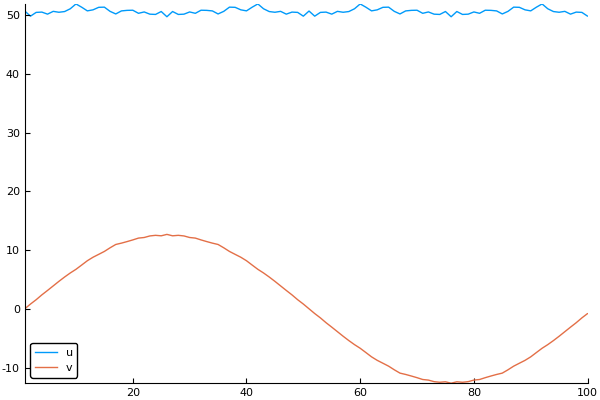

In [21]:
f2 = VectorData(X);
@time H(f2,q);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

In [22]:
Emat = InterpolationMatrix(H,q,f2);

  0.063078 seconds (43.26 k allocations: 2.056 MiB, 8.76% gc time)


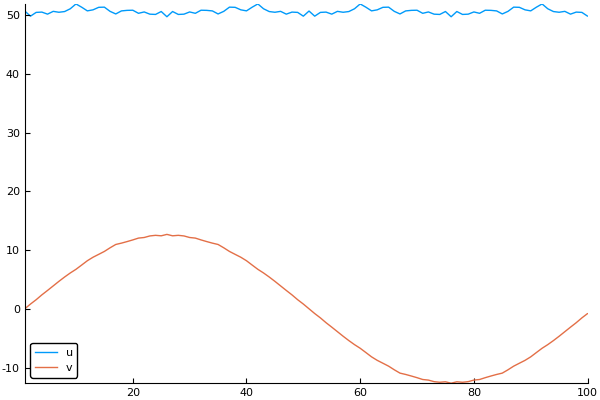

In [23]:
@time f2 = Emat*q
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Vector data onto dual edge field

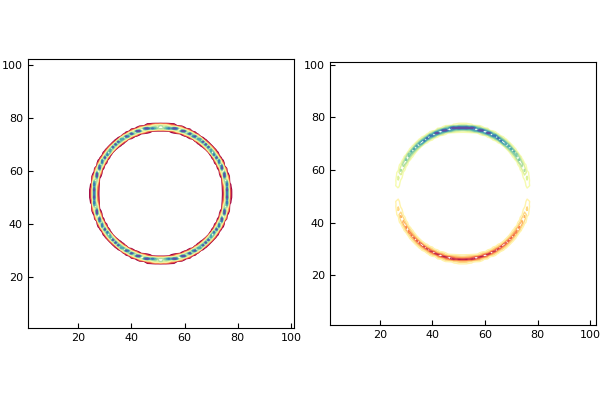

In [24]:
H(p,f);
plot(p)

#### Vector data onto primal and dual nodal data

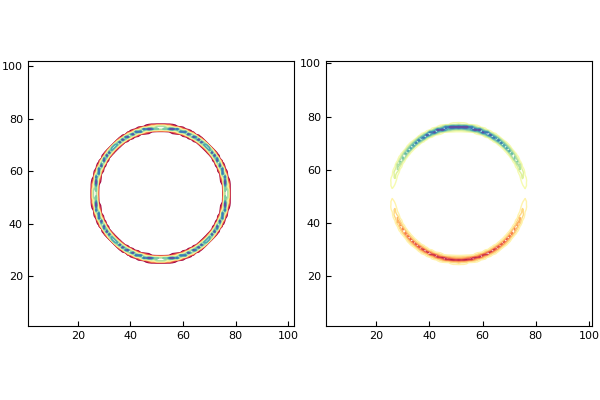

In [27]:
wpair = NodePair(Dual,Primal,(nx,ny))
H(wpair,f);
plot(wpair)

In [28]:
Hmat = RegularizationMatrix(H,f,wpair);

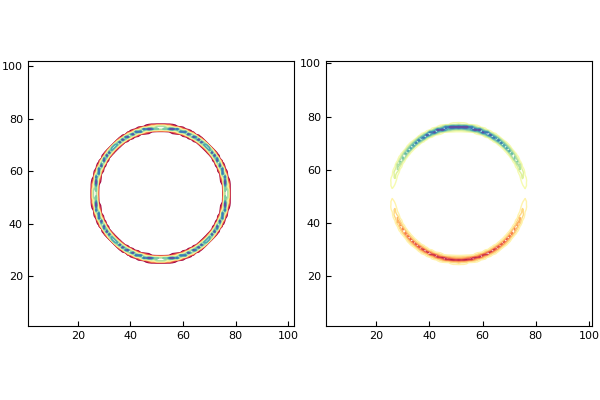

In [29]:
plot(Hmat*f)

In [32]:
wpair.u .= rand(size(wpair.u));
wpair.v .= rand(size(wpair.v));

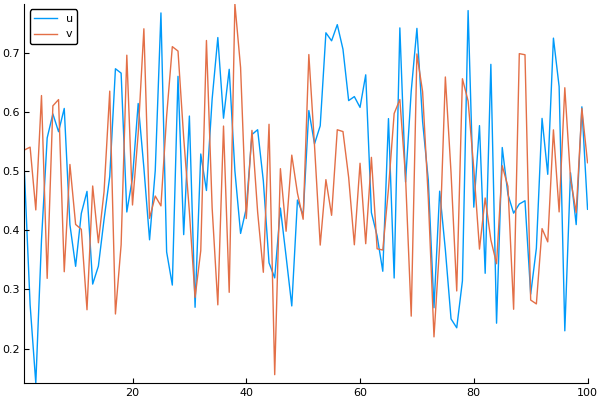

In [33]:
f2 = VectorData(X);
H(f2,wpair);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Scalar data onto dual nodal field

  0.031350 seconds (72.84 k allocations: 27.623 MiB, 22.98% gc time)


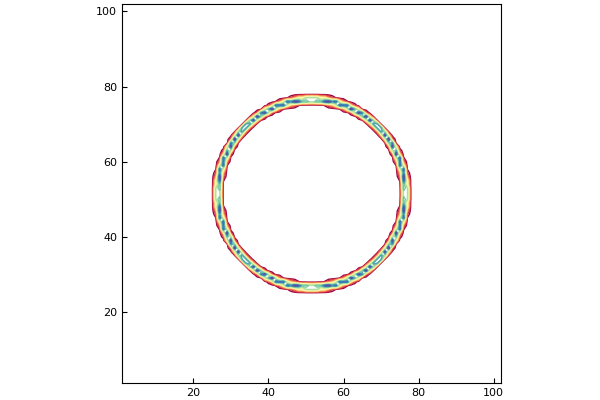

In [22]:
g = ScalarData(X)
fill!(g,1.0)
@time H(w,g)
plot(w)

#### Set up a matrix form of regularization

In [7]:
g = ScalarData(X)
w = Nodes(Dual,(nx,ny));
@time Hmat = RegularizationMatrix(H,g,w);
@time Emat = InterpolationMatrix(H,w,g);

  3.284073 seconds (7.49 M allocations: 2.710 GiB, 8.61% gc time)
  2.821594 seconds (7.29 M allocations: 2.700 GiB, 6.23% gc time)


  0.000023 seconds (8 allocations: 21.188 KiB)


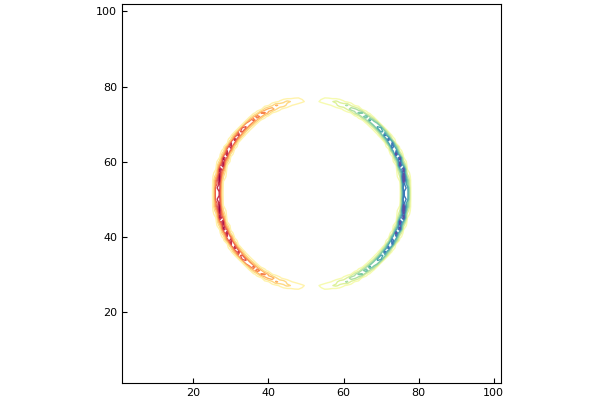

In [14]:
g = ScalarData(X)
g .= X.u-0.5
@time A_mul_B!(w,Hmat,g)
plot(w)

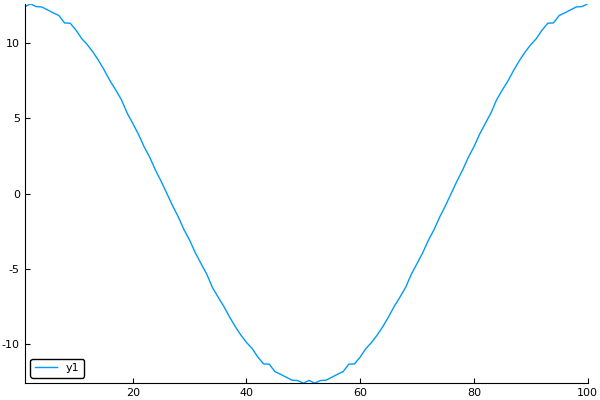

In [15]:
plot(Emat*w)

In [16]:
g = ScalarData(X)
g .= cos.(θ[1:n])+ 0.2*rand(n);

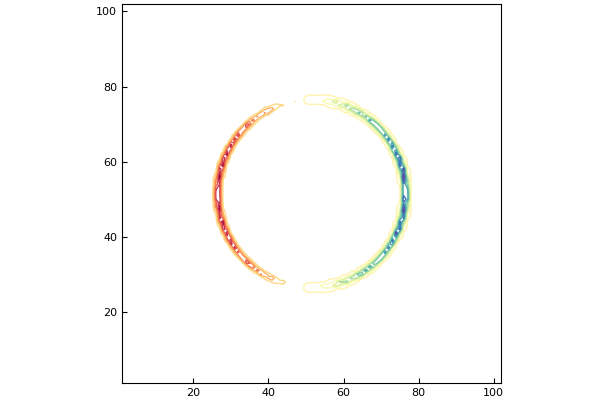

In [19]:
plot(Hmat*g)

In [25]:
g2 = ScalarData(X)
@time H(g2,w);

  0.013124 seconds (72.83 k allocations: 27.624 MiB, 26.55% gc time)


In [21]:
Ẽmat = InterpolationMatrix(H̃,w,g);

  0.067034 seconds (145.67 k allocations: 55.247 MiB, 14.75% gc time)


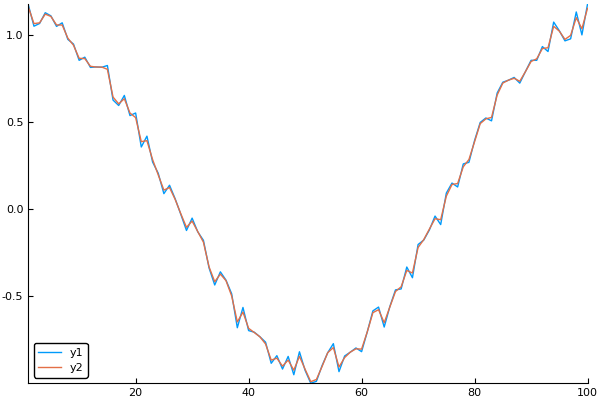

In [23]:
@time H̃(g2,H(w,g));
plot(g)
plot!(g2)

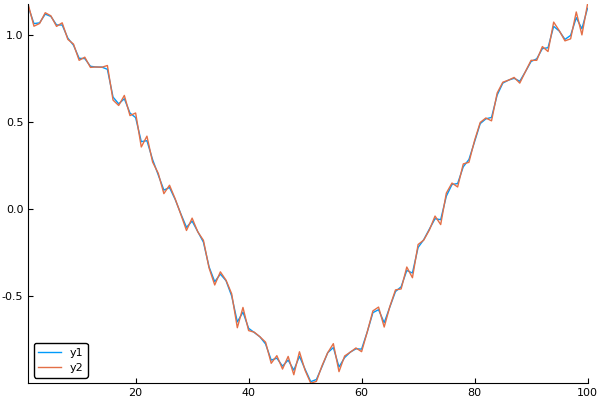

In [24]:
plot(Ẽmat*(Hmat*g))
plot!(g)